In [1]:
"""
Author: Bryan Bo Cao
Email: boca7588@colorado.edu or bo.cao-1@colorado.edu
Github Repo: https://github.com/BryanBo-Cao/neuralnets-deeplearning
Reference:
    https://github.com/tylersco/deep-neural-networks-art-images
    http://www.scipy-lectures.org/advanced/image_processing/
"""
from scipy import misc
import scipy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import glob
import pandas as pd
import csv
import math
from __future__ import division, print_function, absolute_import
from data.img.ArtDataLoader import ArtData
import Plotter
from Plotter import plot_acc_distance
from Plotter import plot_acc_cosine
from Plotter import plot_prob_distance
from Plotter import plot_prob_cosine
from Plotter import plot_2lists
from Plotter import plot_4lists
from MySpearman import get_distance_prob_correlation
from MySpearman import get_cosine_prob_correlation
from MySpearman import get_distance_acc_correlation
from MySpearman import get_cosine_acc_correlation

from scipy.stats import spearmanr

In [2]:
from scipy import misc
art_data = ArtData()
art_data.load_all_data()
#art_data.load_images()
#art_data.load_metadata()

ArtData Initialized!
2592  images loaded!


In [3]:
#print(art_data.train_images.keys())
#Validate
print(art_data.alpha_pairs['same'][0][95])
print(art_data.beta_pairs['same'][0][95])

print(art_data.alpha_pairs['diff'][0][95])
print(art_data.beta_pairs['diff'][0][95])

2018-impressionist-16x16.jpg
2134-impressionist-16x16.jpg
1233-cubist-16x16.jpg
1185-cubist-16x16.jpg


In [4]:
print(art_data.train_images['0001-cubist-16x16.jpg'].shape)

(16, 16, 3)


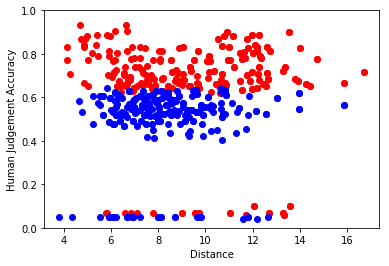

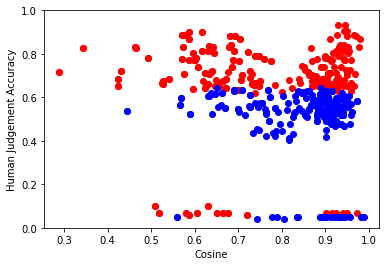

In [5]:
#Raw data - Human Judgement Accuracy
plot_acc_distance(art_data)
plot_acc_cosine(art_data)

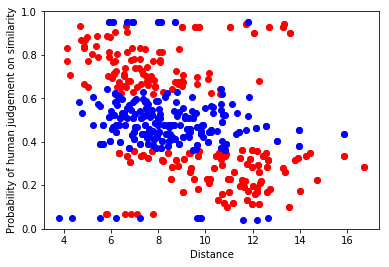

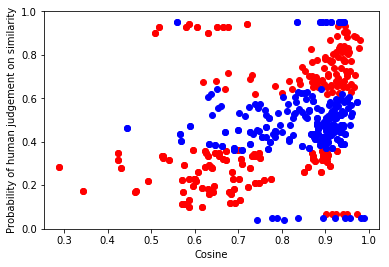

In [6]:
#Raw data - Probability of human judgement on similarity
plot_prob_distance(art_data)
plot_prob_cosine(art_data)

In [7]:
get_distance_prob_correlation(art_data)

SpearmanrResult(correlation=-0.4531196797090763, pvalue=1.6549967874513576e-30)

In [8]:
get_cosine_prob_correlation(art_data)

SpearmanrResult(correlation=0.42701803307779929, pvalue=6.2551843304760119e-27)

In [9]:
get_distance_acc_correlation(art_data)

SpearmanrResult(correlation=0.18460752476813316, pvalue=8.2212500213044036e-06)

In [10]:
get_cosine_acc_correlation(art_data)

SpearmanrResult(correlation=-0.23142047705047938, pvalue=1.9265333564185278e-08)

In [11]:
#start of autoencoder
'''
Reference:
https://github.com/MorvanZhou/tutorials/edit/master/tensorflowTUT/tf21_autoencoder/full_code.py
My tutorial website: https://morvanzhou.github.io/tutorials/
'''
learning_rate = 0.02
training_epochs = 500
batch_size = 256
display_step = 5
# Network Parameters
n_input = 768 # image data input (img shape: 16*16*3)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

# hidden layer settings
n_hidden_1 = 384 # 1st layer num features

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
}

# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    layer_1 = tf.layers.dropout(layer_1, rate=0.5)
    return layer_1


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    return layer_1

In [12]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
y_bottleneck = encoder_op

# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


# Launch the graph
with tf.Session() as sess:
    # tf.initialize_all_variables() no long valid from
    # 2017-03-02 if using tensorflow >= 0.12
    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        init = tf.initialize_all_variables()
    else:
        init = tf.global_variables_initializer()
    sess.run(init)
    total_batch = int(len(art_data.train_images) / batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = art_data.next_batch(batch_size)  # max(x) = 1, min(x) = 0
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")
    
    #alpha
    encode_output_alpha_a = sess.run(
        y_bottleneck, feed_dict={X: art_data.alpha_set_flatten[0]})
    encode_output_alpha_b = sess.run(
        y_bottleneck, feed_dict={X: art_data.alpha_set_flatten[1]})
    
    encode_decode_output_alpha_a = sess.run(
        y_pred, feed_dict={X: art_data.alpha_set_flatten[0]})
    encode_decode_output_alpha_b = sess.run(
        y_pred, feed_dict={X: art_data.alpha_set_flatten[1]})
    
    #beta
    encode_output_beta_a = sess.run(
        y_bottleneck, feed_dict={X: art_data.beta_set_flatten[0]})
    encode_output_beta_b = sess.run(
        y_bottleneck, feed_dict={X: art_data.beta_set_flatten[1]})
    
    encode_decode_output_beta_a = sess.run(
        y_pred, feed_dict={X: art_data.beta_set_flatten[0]})
    encode_decode_output_beta_b = sess.run(
        y_pred, feed_dict={X: art_data.beta_set_flatten[1]})
  
encode_outout_alpha_a = encode_output_alpha_a.tolist()
encode_output_alpha_b = encode_output_alpha_b.tolist()

encode_decode_output_alpha_a = encode_decode_output_alpha_a.tolist()
encode_decode_output_alpha_b = encode_decode_output_alpha_b.tolist()

encode_output_beta_a = encode_output_beta_a.tolist()
encode_output_beta_b = encode_output_beta_b.tolist()

encode_decode_output_beta_a = encode_decode_output_beta_a.tolist()
encode_decode_output_beta_b = encode_decode_output_beta_b.tolist()

Epoch: 0001 cost= 0.189473748
Epoch: 0006 cost= 0.115675151
Epoch: 0011 cost= 0.106633492
Epoch: 0016 cost= 0.106239229
Epoch: 0021 cost= 0.104285903
Epoch: 0026 cost= 0.103873290
Epoch: 0031 cost= 0.106077515
Epoch: 0036 cost= 0.104825564
Epoch: 0041 cost= 0.102760978
Epoch: 0046 cost= 0.099649049
Epoch: 0051 cost= 0.100068420
Epoch: 0056 cost= 0.101152636
Epoch: 0061 cost= 0.103878133
Epoch: 0066 cost= 0.096358739
Epoch: 0071 cost= 0.101446509
Epoch: 0076 cost= 0.101077311
Epoch: 0081 cost= 0.100522555
Epoch: 0086 cost= 0.103484713
Epoch: 0091 cost= 0.100840069
Epoch: 0096 cost= 0.100789823
Epoch: 0101 cost= 0.099486001
Epoch: 0106 cost= 0.099580623
Epoch: 0111 cost= 0.098885566
Epoch: 0116 cost= 0.103046127
Epoch: 0121 cost= 0.093420126
Epoch: 0126 cost= 0.100589372
Epoch: 0131 cost= 0.101219095
Epoch: 0136 cost= 0.100682043
Epoch: 0141 cost= 0.100002229
Epoch: 0146 cost= 0.097932033
Epoch: 0151 cost= 0.098218083
Epoch: 0156 cost= 0.096739806
Epoch: 0161 cost= 0.099844985
Epoch: 016

In [13]:
#alpha

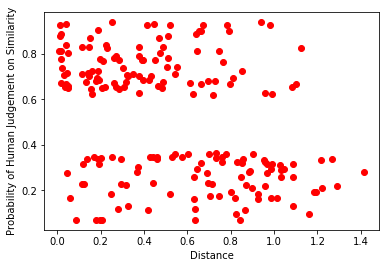

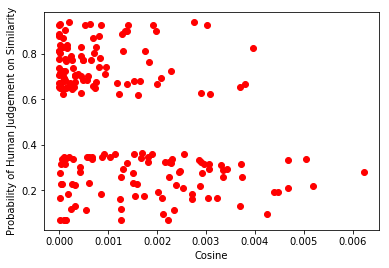

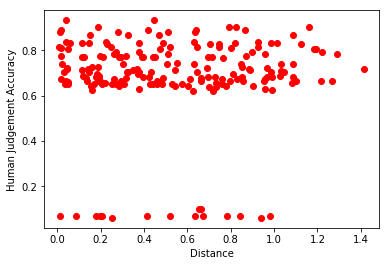

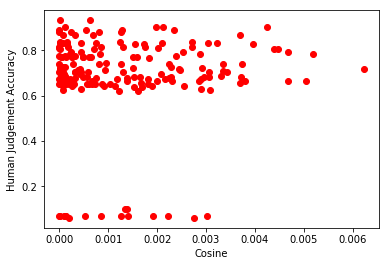

In [14]:
#alpha bottleneck output
#distance, cosine, prob_human_similarity, accuracy
encode_output_alpha_distance = art_data.get_distance_list_flatten(encode_output_alpha_a, encode_output_alpha_b)
encode_output_alpha_cosine = art_data.get_cosine_list_flatten(encode_output_alpha_a, encode_output_alpha_b)
plot_2lists(
    encode_output_alpha_distance, art_data.alpha_prob_human_similarity, 
    "Distance", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_output_alpha_cosine, art_data.alpha_prob_human_similarity,
    "Cosine", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_output_alpha_distance, art_data.alpha_accuracy, 
    "Distance", "Human Judgement Accuracy")
plot_2lists(
    encode_output_alpha_cosine, art_data.alpha_accuracy,
    "Cosine", "Human Judgement Accuracy")

In [15]:
#alpha bottleneck output
#distance, prob_human_similarity
spearmanr(encode_output_alpha_distance, art_data.alpha_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.36153475613735642, pvalue=2.5744184889469188e-07)

In [16]:
#alpha bottleneck output
#cosine, prob_human_similarity
spearmanr(encode_output_alpha_cosine, art_data.alpha_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.36118375563541383, pvalue=2.649171208539846e-07)

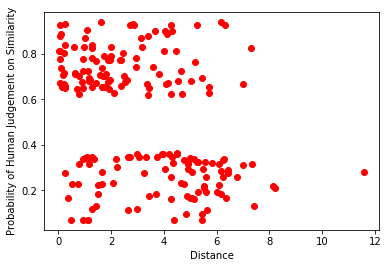

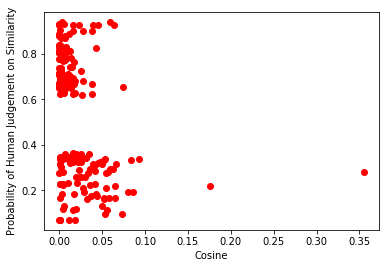

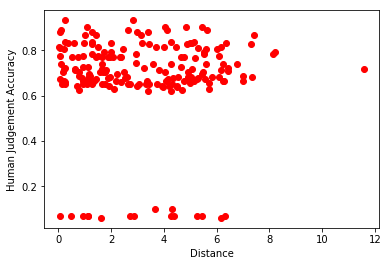

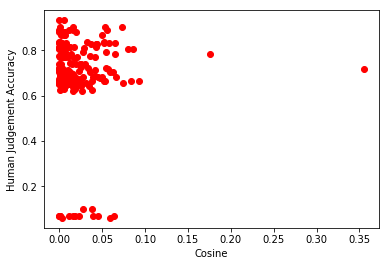

In [17]:
#alpha network output
#distance, cosine, prob_human_similarity
encode_decode_output_alpha_distance = art_data.get_distance_list_flatten(
                    encode_decode_output_alpha_a, encode_decode_output_alpha_b)
encode_decode_output_alpha_cosine = art_data.get_cosine_list_flatten(
                    encode_decode_output_alpha_a, encode_decode_output_alpha_b)
plot_2lists(
    encode_decode_output_alpha_distance, art_data.alpha_prob_human_similarity,
    "Distance", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_decode_output_alpha_cosine, art_data.alpha_prob_human_similarity,
    "Cosine", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_decode_output_alpha_distance, art_data.alpha_accuracy,
    "Distance", "Human Judgement Accuracy")
plot_2lists(
    encode_decode_output_alpha_cosine, art_data.alpha_accuracy,
    "Cosine", "Human Judgement Accuracy")

In [18]:
#alpha, network output
#distance, prob_human_similarity
spearmanr(encode_decode_output_alpha_distance, art_data.alpha_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.34882243361047938, pvalue=7.1040307129305638e-07)

In [19]:
#alpha, network output
#cosine, prob_human_similarity
spearmanr(encode_decode_output_alpha_cosine, art_data.alpha_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.38239385118395863, pvalue=4.4133453215975446e-08)

In [20]:
#beta

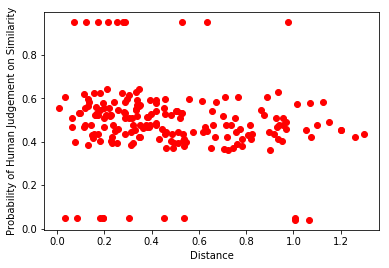

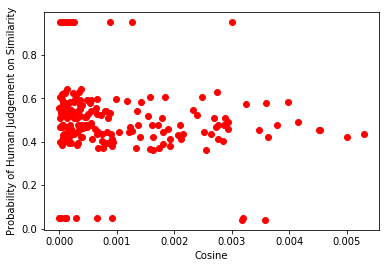

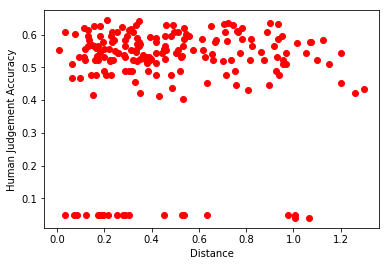

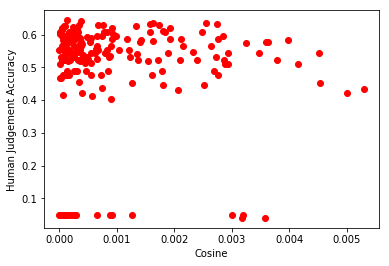

In [21]:
#beta, bottleneck output
#distance, cosine, prob_human_similarity, accuracy
encode_output_beta_distance = art_data.get_distance_list_flatten(encode_output_beta_a, encode_output_beta_b)
encode_output_beta_cosine = art_data.get_cosine_list_flatten(encode_output_beta_a, encode_output_beta_b)
plot_2lists(
    encode_output_beta_distance, art_data.beta_prob_human_similarity,
    "Distance", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_output_beta_cosine, art_data.beta_prob_human_similarity,
    "Cosine", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_output_beta_distance, art_data.beta_accuracy,
    "Distance", "Human Judgement Accuracy")
plot_2lists(
    encode_output_beta_cosine, art_data.beta_accuracy,
    "Cosine", "Human Judgement Accuracy")

In [22]:
#beta, bottleneck output
#distance, prob_human_similarity
spearmanr(encode_output_beta_distance, art_data.beta_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.2162578866989579, pvalue=0.0025891553010068632)

In [23]:
#beta, bottleneck output
#cosine, prob_human_similarity
spearmanr(encode_output_beta_cosine, art_data.beta_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.21648004797027873, pvalue=0.0025622369005876872)

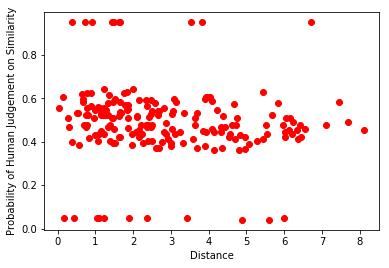

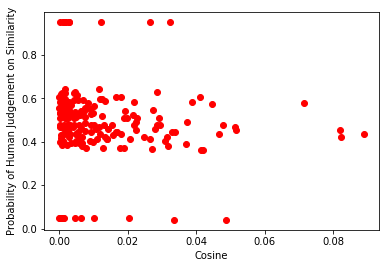

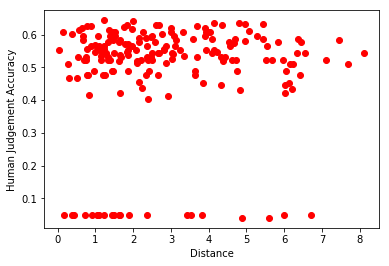

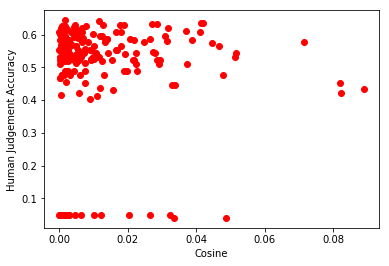

In [24]:
#beta, network output
#distance, cosine, prob_human_similarity
encode_decode_output_beta_distance = art_data.get_distance_list_flatten(
                    encode_decode_output_beta_a, encode_decode_output_beta_b)
encode_decode_output_beta_cosine = art_data.get_cosine_list_flatten(
                    encode_decode_output_beta_a, encode_decode_output_beta_b)
plot_2lists(
    encode_decode_output_beta_distance, art_data.beta_prob_human_similarity,
    "Distance", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_decode_output_beta_cosine, art_data.beta_prob_human_similarity,
    "Cosine", "Probability of Human Judgement on Similarity")
plot_2lists(
    encode_decode_output_beta_distance, art_data.beta_accuracy,
    "Distance", "Human Judgement Accuracy")
plot_2lists(
    encode_decode_output_beta_cosine, art_data.beta_accuracy,
    "Cosine", "Human Judgement Accuracy")

In [25]:
#beta, network output
#distance, prob_human_similarity
spearmanr(encode_decode_output_beta_distance, art_data.beta_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.22030851415353692, pvalue=0.0021365306330225803)

In [26]:
#beta, network output
#cosine, prob_human_similarity
spearmanr(encode_decode_output_beta_cosine, art_data.beta_prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.18703096036351111, pvalue=0.0093873191790612397)

In [27]:
#alpha & beta

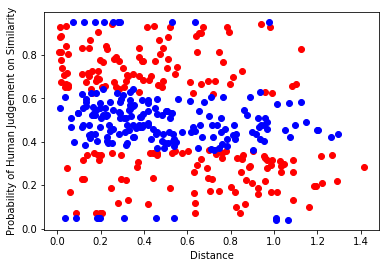

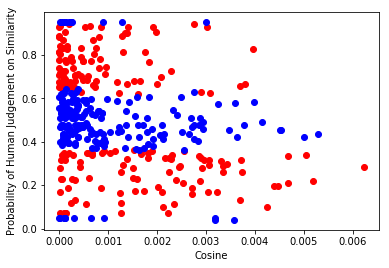

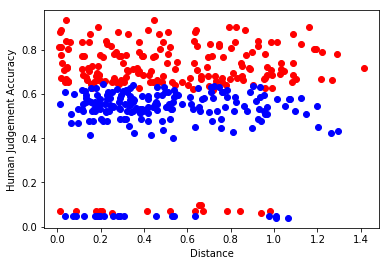

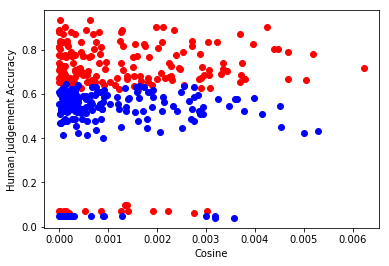

In [28]:
#alpha & beta bottleneck output
#distance, cosine, prob_human_similarity
encode_output_distance = []
encode_output_distance.extend(encode_output_alpha_distance)
encode_output_distance.extend(encode_output_beta_distance)

encode_output_cosine = []
encode_output_cosine.extend(encode_output_alpha_cosine)
encode_output_cosine.extend(encode_output_beta_cosine)

prob_human_similarity = []
prob_human_similarity.extend(art_data.alpha_prob_human_similarity)
prob_human_similarity.extend(art_data.beta_prob_human_similarity)

accuracy = []
accuracy.extend(art_data.alpha_accuracy)
accuracy.extend(art_data.alpha_accuracy)

plot_4lists(encode_output_alpha_distance, art_data.alpha_prob_human_similarity,
            encode_output_beta_distance, art_data.beta_prob_human_similarity,
            "Distance", "Probability of Human Judgement on Similarity")
plot_4lists(encode_output_alpha_cosine, art_data.alpha_prob_human_similarity,
            encode_output_beta_cosine, art_data.beta_prob_human_similarity,
            "Cosine", "Probability of Human Judgement on Similarity")

plot_4lists(encode_output_alpha_distance, art_data.alpha_accuracy,
            encode_output_beta_distance, art_data.beta_accuracy,
            "Distance", "Human Judgement Accuracy")
plot_4lists(encode_output_alpha_cosine, art_data.alpha_accuracy,
            encode_output_beta_cosine, art_data.beta_accuracy,
            "Cosine", "Human Judgement Accuracy")

In [29]:
#alpha & beta, bottlenect output
#distance, prob_human_similarity
spearmanr(encode_output_distance, prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.31084006297753797, pvalue=4.7775536472607919e-10)

In [30]:
#alpha & beta, bottlenect output
#cosine, prob_human_similarity
spearmanr(encode_output_cosine, prob_human_similarity, axis=None)

SpearmanrResult(correlation=-0.31072264891407186, pvalue=4.8535851471037508e-10)

In [31]:
#alpha & beta, bottlenect output
#distance, accuracy
spearmanr(encode_output_distance, accuracy, axis=None)

SpearmanrResult(correlation=-0.019203894475395059, pvalue=0.70756698102410953)

In [32]:
#alpha & beta, bottlenect output
#distance, accuracy
spearmanr(encode_output_distance, accuracy, axis=None)

SpearmanrResult(correlation=-0.019203894475395059, pvalue=0.70756698102410953)

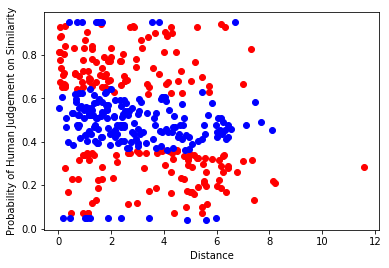

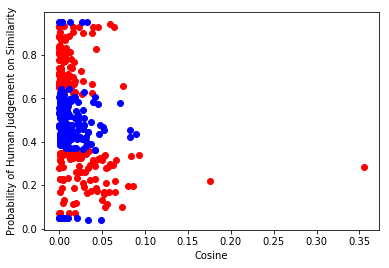

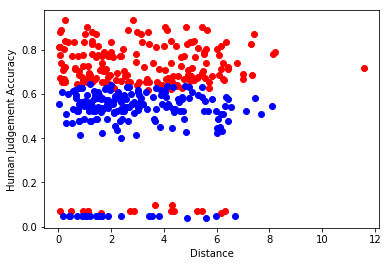

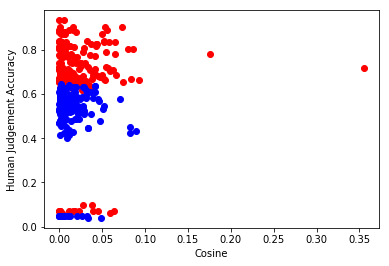

In [33]:
#alpha & beta bottleneck output
#distance, cosine, prob_human_similarity
encode_decode_output_distance = []
encode_decode_output_distance.extend(encode_decode_output_alpha_distance)
encode_decode_output_distance.extend(encode_decode_output_beta_distance)

encode_decode_output_cosine = []
encode_decode_output_cosine.extend(encode_decode_output_alpha_cosine)
encode_decode_output_cosine.extend(encode_decode_output_beta_cosine)

'''
prob_human_similarity = []
prob_human_similarity.extend(art_data.alpha_prob_human_similarity)
prob_human_similarity.extend(art_data.beta_prob_human_similarity)

accuracy = []
accuracy.extend(art_data.alpha_accuracy)
accuracy.extend(art_data.alpha_accuracy)
'''

plot_4lists(encode_decode_output_alpha_distance, art_data.alpha_prob_human_similarity,
            encode_decode_output_beta_distance, art_data.beta_prob_human_similarity,
            "Distance", "Probability of Human Judgement on Similarity")
plot_4lists(encode_decode_output_alpha_cosine, art_data.alpha_prob_human_similarity,
            encode_decode_output_beta_cosine, art_data.beta_prob_human_similarity,
            "Cosine", "Probability of Human Judgement on Similarity")

plot_4lists(encode_decode_output_alpha_distance, art_data.alpha_accuracy,
            encode_decode_output_beta_distance, art_data.beta_accuracy,
            "Distance", "Human Judgement Accuracy")
plot_4lists(encode_decode_output_alpha_cosine, art_data.alpha_accuracy,
            encode_decode_output_beta_cosine, art_data.beta_accuracy,
            "Cosine", "Human Judgement Accuracy")